# Reweighting Mechanisms Explanation

This notebook serves as documentation explaining the `ReweightingMechanism` class, found in `mechanisms.reweighting`. 

## Custom Types

Reweighting Mechanisms use a number of custom types, found in `mechanisms.reweighting_types`:

* `Credential`: a string giving the name of a credential (e.g. an NFT)
* `GroupName`: a string giving the name of a group of credentials to be reweighted (e.g. "Experts", "Blue Team", etc.)
* `VoterData`: a DataFrame giving information about which voters hold which credentials 
* `GroupRule`: a rule specifying how a group should be weighted. Each `GroupWeightRule` consists of three things. 
        - `selection_rule`: Determines which cells should be selected to use in the rule. This should be a function that takes as input a row from a `VoterData` DataFrame, and returns `True` or `False` depending on whether that row should be eligible for group membership.
        - `credentials_to_sum`: a list of strings, specifying which credentials from a given row should be added when calculating the group's *cweight*.
        - `credentials_to_reweight`: a list of strings, specifying which credentials from a given row should be re-weighted when this group is processed. 

* `GroupRuleDict`: a dictionary specifying which `GroupRule` should be used for each group. To be valid for use, the `credentials_to_reweight` from all keys in the `GroupRuleDict` should contain every credential exactly once, and the `selection_rule`s overall keys should cover each cell in `VoterData` exactly once. 


* `GroupMask`: a DataFrame consisting of 0 or 1 in each entry, used to filter specific values from a larger DataFrame. 
* `GroupMaskRulesDict`: a dictionary specifying which `GroupMask` should be used for each group.
* `NewCredentialRule`: a logical rule for creating a new credential, such as a credential that should only be issued if someone has a combination of other credentials.
* `NewCredentialRuleDict`: a dictionary that tells the names of new credentials to be created, along with rules for how they will be. 

In [1]:
import sys
sys.path.append('..')

import numpy as np

from copy import deepcopy

from mechanisms.reweighting_types import *
from mechanisms.reweighting import ReweightingMechanism
from mechanisms.proportional_reweighting import ProportionalReweightingMechanism
from mechanisms.ordered_reweighting import OrderedReweightingMechanism

In [2]:
# Reading voter credential data from a csv file 
example_voter_data = pd.read_csv("data/upper_triangular_color_voter_data.csv", index_col=0)

In [3]:
example_voter_data

,red_1,red_2,blue_1,blue_2,yellow_1,yellow_2
voter_0,1,1,1,1,1,1
voter_1,0,1,1,1,1,1
voter_2,0,0,1,1,1,1
voter_3,0,0,0,1,1,1
voter_4,0,0,0,0,1,1
voter_5,0,0,0,0,0,1


## Context

For this data set, the organization wants to create three groups: 
1. **Red:** Consisting of the `red` credentials (i.e. `red_1` and `red_2`)
2. **Green:** Consisting of `blue` and `yellow` credentials, for users who hold ALL possible `blue` and `yellow` credentials. In other words, this group only counts if the account holds each of `blue_1`, `blue_2`, `yellow_1`, and `yellow_2`. 
3.  **Other:** This consists of everything else: `blue` and `yellow` credentials for users who do not qualify for **Green** status, i.e. do not hold all possible `blue` and `yellow` credentials. 

## Creating a new credential, based on a specific rule 

* For the scenario we have, it is easier to create a `green` credential and assign it to each voter who has all of `blue_1`, `blue_2`, `green_1`, and `green_2`. 
* For this purpose, we create a `NewCredentialRule`, that gives the precise conditions under which a voter qualifies as green. 
* We associate the `NewCredentialRule` with its name in a dictionary. 

In [4]:
def is_green_voter(voter_info: pd.Series):
    """
    An indicator function: returns 1 if the voter has all blue and yellow NFTs
    0 if not. 
    """
    is_green = int(voter_info[["blue_1", "blue_2", "yellow_1", "yellow_2"]].all())
    return is_green

In [5]:
# Create two example voters: one green, one not. 
color_index = [col for col in example_voter_data.columns]
not_green_voter = pd.Series([1, 0, 1, 0, 0, 1], index=color_index)
green_voter = pd.Series([0,0,1,1,1,1], index=color_index)

In [6]:
is_green_voter(not_green_voter)

0

In [7]:
is_green_voter(green_voter)

1

To use this in a `ReweightingMechanism`, we need to make sure that the `NewCredentialRule` is associated with a credential name. 

In [8]:
new_credential_rules = {"green": is_green_voter}

## Creating a Group Rule

Let's create a `GroupRule` for each group mentioned in the Scenario: **Red**, **Green**, and **Other**. 

### CReating The Group Rule for Red



* For **Red**, any cell is eligible, so the `selection_rule` should simply return `True`. The `creds_to_sum` and `creds_to_reweight` consist of the same credentials: `red_1` and `red_2`. 

Here's what that looks like in Python code. 

In [9]:
red_group_rule = GroupRule(selection_rule= lambda account: True,
                           credentials_to_sum=["red_1","red_2"],
                           credentials_to_reweight=["red_1","red_2"])

* For **Other**, the `selection_rule` should consider accounts that don't have the `green` credential. It should add up all of their `blue` and `yellow` credentials for the non-green accounts, then re-weight these credentials accordingly. Here's what that looks like in Python code.

Notice that we are including `green` in `credentials_to_sum` to satisfy the *completely exhaustive* criterion, we know that it will not contribute anything to the total `cweight` since all `green` entries will be equal to 0. 

In [10]:
other_group_rule = GroupRule(selection_rule = lambda account: not account["green"],
                            credentials_to_sum = ["yellow_1", "yellow_2", "blue_1", "blue_2", "green"],
                            credentials_to_reweight= ["yellow_1", "yellow_2", "blue_1", "blue_2"])

* For **Green**, the `selection_rule` should consider accounts that do have the . It should add up all of their `blue` and `yellow` credentials for the non-green accounts, then re-weight these credentials accordingly. Here's what that looks like in Python code. 

In [11]:

green_group_rule = GroupRule(selection_rule = lambda account: account["green"],
                            credentials_to_sum = ["yellow_1", "yellow_2", "blue_1", "blue_2", "green"],
                            credentials_to_reweight= ["green"])


To use these rules, we can put them in a `GroupRulesDict` that associates each rule with a group name. 

In [12]:
color_group_rules = {"red": red_group_rule, 
               "other": other_group_rule,
               "green": green_group_rule}

## Setting Initial Weights for Credentials

Initial weights for credentials need to be set by a human decision-maker. Reweighting Mechanisms will respect the proportional relationships established within the initial weights. 

In [13]:
initial_credential_weights = {"red_1": 5.0, 
                             "red_2": 10.0, 
                             "blue_1": 1.0, 
                             "blue_2": 2.0, 
                             "yellow_1": 1.0,
                             "yellow_2": 3.0,
                             "green": 2.0}

# NOTE: It's also possible to input these from a data frame. 

## Creating a `ReweightingMechanism` object


In [14]:
rm = ReweightingMechanism(initial_voter_data = example_voter_data,
                          new_credentials = new_credential_rules,
                          group_rules = color_group_rules,
                          initial_credential_weights = initial_credential_weights)

### Updating Voter Data to Reflect New Credentials 

The `initial_voter_data` DataFrame will not have the new credentials that are being created. For instance, `toy_dataframe` above does not have a `green` column, since this credential will be created. 

In the process of constructing the `ReweightingMechanism` object, a `current_voter_data` attribute is created. This `current_voter_data` contains the data from `initial_voter_data`, as well as any new credentials created from a `NewCredentialRule`. 

In [15]:
rm.current_voter_data

,red_1,red_2,blue_1,blue_2,yellow_1,yellow_2,green
voter_0,1,1,1,1,1,1,1
voter_1,0,1,1,1,1,1,1
voter_2,0,0,1,1,1,1,1
voter_3,0,0,0,1,1,1,0
voter_4,0,0,0,0,1,1,0
voter_5,0,0,0,0,0,1,0


## Creating Group Masks

**Group Masks** are used to partition the entries in a `VoterData` object, so that only the entries for each group are used for that group's calculations.
Technically, a group mask is a `DataFrame` that consists only of 0's and 1's. Each group name is associated to a group mask in a `GroupMaskDict` object. 

This information is stored in the `group_masks` attribute of the `ReweightingMechanism`. 

In [16]:
group_masks = rm.group_masks
group_masks.get("red")

,red_1,red_2,blue_1,blue_2,yellow_1,yellow_2,green
voter_0,1,1,0,0,0,0,0
voter_1,1,1,0,0,0,0,0
voter_2,1,1,0,0,0,0,0
voter_3,1,1,0,0,0,0,0
voter_4,1,1,0,0,0,0,0
voter_5,1,1,0,0,0,0,0


In [17]:
group_masks.get("green")

,red_1,red_2,blue_1,blue_2,yellow_1,yellow_2,green
voter_0,0,0,1,1,1,1,1
voter_1,0,0,1,1,1,1,1
voter_2,0,0,1,1,1,1,1
voter_3,0,0,0,0,0,0,0
voter_4,0,0,0,0,0,0,0
voter_5,0,0,0,0,0,0,0


In [18]:
group_masks.get("other")

,red_1,red_2,blue_1,blue_2,yellow_1,yellow_2,green
voter_0,0,0,0,0,0,0,0
voter_1,0,0,0,0,0,0,0
voter_2,0,0,0,0,0,0,0
voter_3,0,0,1,1,1,1,1
voter_4,0,0,1,1,1,1,1
voter_5,0,0,1,1,1,1,1


In [19]:
rm.check_valid_masks(voter_data = rm.current_voter_data,
                     group_masks = rm.group_masks)

True

### Creating Current Credential Weights

Each instance of `ReweightingMechanism` has an attribute called `current_credential_weights`, which tracks the weight of each credential. 

Initially, current credential weights are set to be initial credential weights.
The `update_all_current_credential_weights` method changes the `current_credential_weights`. This method is simply a placeholder in `ReweightingMechanism`, and any subclass must implement its own version. 

**Important Note:** When creating the `group_rules`, the order of the rules **does** matter. 
Each credential's weight will only be updated once when calling the mechanism's `update_all_current_credential_weights` method. 
This method needs to be implemented for each subclass. 

## Proportional Reweighting Mechanism

The `ProportionalReweightingMechanism` class, found in `mechanisms.proportional_reweighting`, extends the `ReweightingMechanism` class to focus on achieving specific proportions in terms of group cweight.

For instance, in our example, we might want to specify that the `red` credentials account for 50% of total voting weight, while `green` accounts for 35%, and `other` accounts for 15%. We can specify this by creating a `group_proportions` dictionary, which is passed as an argument into the `ProportionalReweightingMechanism` constructor. 

In [20]:
# Define group proportions

example_group_proportions = {"red": 0.5, 
                    "green": 0.35,
                     "other": 0.15}

In [21]:
# Define a ProportionalReweightingMechanism

prm = ProportionalReweightingMechanism(initial_voter_data = example_voter_data,
                                       new_credentials = new_credential_rules,
                                       group_rules = color_group_rules,
                                       initial_credential_weights = initial_credential_weights,
                                       group_proportions = example_group_proportions
                                       )

In addition to `modified_voter_data` and `group_rules`, the mechanism takes other arguments. 

In [22]:
prm.target_cweights

{'red': 43.333333333333336, 'green': 30.333333333333336, 'other': 13.0}

In [23]:
initial_cweights = prm.calc_all_group_cweights()
initial_cweights

{'red': 25.0, 'other': 13.0, 'green': 27.0}

In [24]:
prm.current_credential_weights

{'red_1': 5.0,
 'red_2': 10.0,
 'blue_1': 1.0,
 'blue_2': 2.0,
 'yellow_1': 1.0,
 'yellow_2': 3.0,
 'green': 2.0}

In [25]:
prm.update_all_current_credential_weights()

(True,
 {'red_1': 8.666666666666668,
  'red_2': 17.333333333333336,
  'blue_1': 1.0,
  'blue_2': 2.0,
  'yellow_1': 1.0,
  'yellow_2': 3.0,
  'green': 3.111111111111112})

In [26]:
final_cweights = prm.calc_all_group_cweights()
final_cweights

{'red': 43.33333333333334, 'other': 13.0, 'green': 30.333333333333336}

## Finding Voter Weights

We can calculate weights of a single voter, a group of voters, or all voters. 

In [27]:
voter_1_weight = prm.calc_individual_voter_weight(voter_data_to_use = prm.current_voter_data, 
                                 weights_to_use = prm.current_credential_weights,
                                 voter = "voter_1")
voter_1_weight

27.444444444444446

In [28]:
voter_group = ["voter_1","voter_3"]
prm.calc_voter_weights(voter_group)

{'voter_1': {'weight': 27.444444444444446}, 'voter_3': {'weight': 6.0}}

In [29]:
final_voter_weights = prm.calc_all_voter_weights()
final_voter_weights

{'voter_0': {'weight': 36.111111111111114},
 'voter_1': {'weight': 27.444444444444446},
 'voter_2': {'weight': 10.111111111111112},
 'voter_3': {'weight': 6.0},
 'voter_4': {'weight': 4.0},
 'voter_5': {'weight': 3.0}}

## Ordered Weighting Mechanism

The `OrderedReweightingMechanism` class, found in `mechanisms.ordered_reweighting` extends `ReweightingMechanism`. 
An instance of `OrderedWeightingMechanism` must have `group_order`, a list which should contain every group name exactly once. 
When the `update_all_current_credentials` method is called, credentials are re-weighted so that group weights are in non-decreasing order, starting with the first group in the list. 

In [30]:
example_group_order = ["other", "green", "red"]

orm = OrderedReweightingMechanism(initial_voter_data = example_voter_data,
                                       new_credentials = new_credential_rules,
                                       group_rules = color_group_rules,
                                       initial_credential_weights = initial_credential_weights,
                                       group_order= example_group_order 
                                       )

In [31]:
orm.calc_all_group_cweights()

{'red': 25.0, 'other': 13.0, 'green': 27.0}

In [32]:
orm.target_cweights

{'other': 13.0, 'green': 27.0, 'red': 27.0}

In [33]:
orm.update_all_current_credential_weights()

(True,
 {'red_1': 5.4,
  'red_2': 10.8,
  'blue_1': 1.0,
  'blue_2': 2.0,
  'yellow_1': 1.0,
  'yellow_2': 3.0,
  'green': 2.0})

In [34]:
orm.current_credential_weights

{'red_1': 5.4,
 'red_2': 10.8,
 'blue_1': 1.0,
 'blue_2': 2.0,
 'yellow_1': 1.0,
 'yellow_2': 3.0,
 'green': 2.0}

In [35]:
orm.calc_all_group_cweights()

{'red': 27.0, 'other': 13.0, 'green': 27.0}

## Visualizing Voter Weights and Group cWeights

The `utils.visualization` module includes a number of tools for visually comparing before-and-after weight distributions. 

In [36]:
from utils.visualization import *

In [37]:
# Get initial voter weights
initial_voter_weights = prm.calc_all_voter_weights(weights_to_use = initial_credential_weights)

# Need to convert to list for use 
initial_voter_weights_data = [initial_voter_weights.get(voter).get("weight") for voter in initial_voter_weights.keys()]

# Get final voter weights and convert to list for use
final_voter_weights = prm.calc_all_voter_weights()
final_voter_weights_data = [final_voter_weights.get(voter).get("weight") for voter in final_voter_weights.keys()]

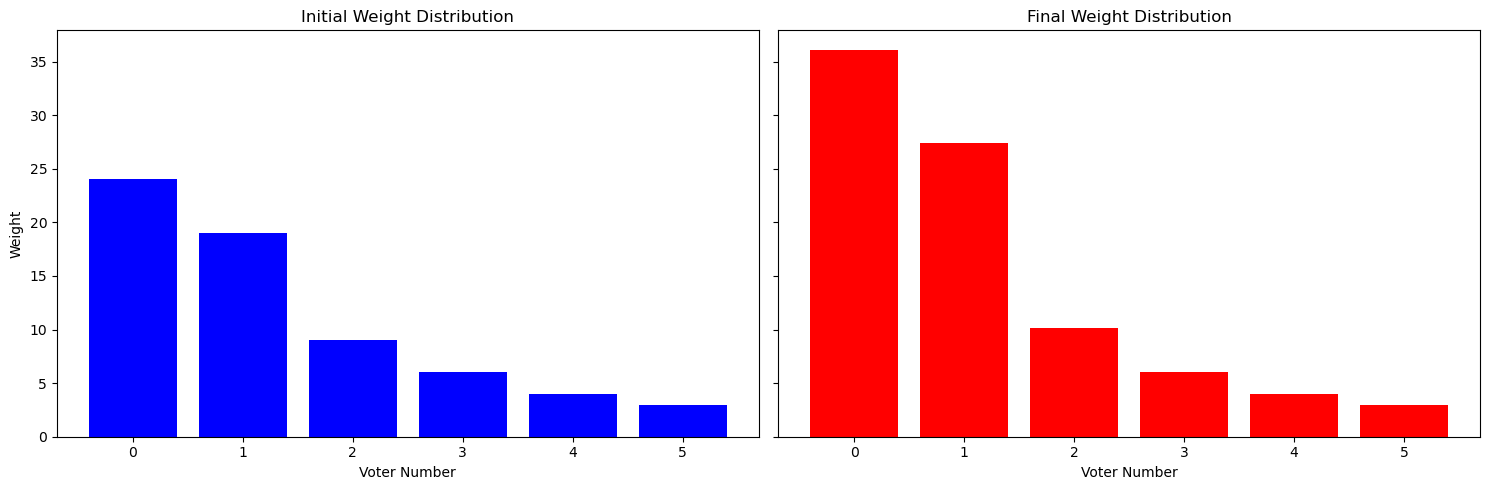

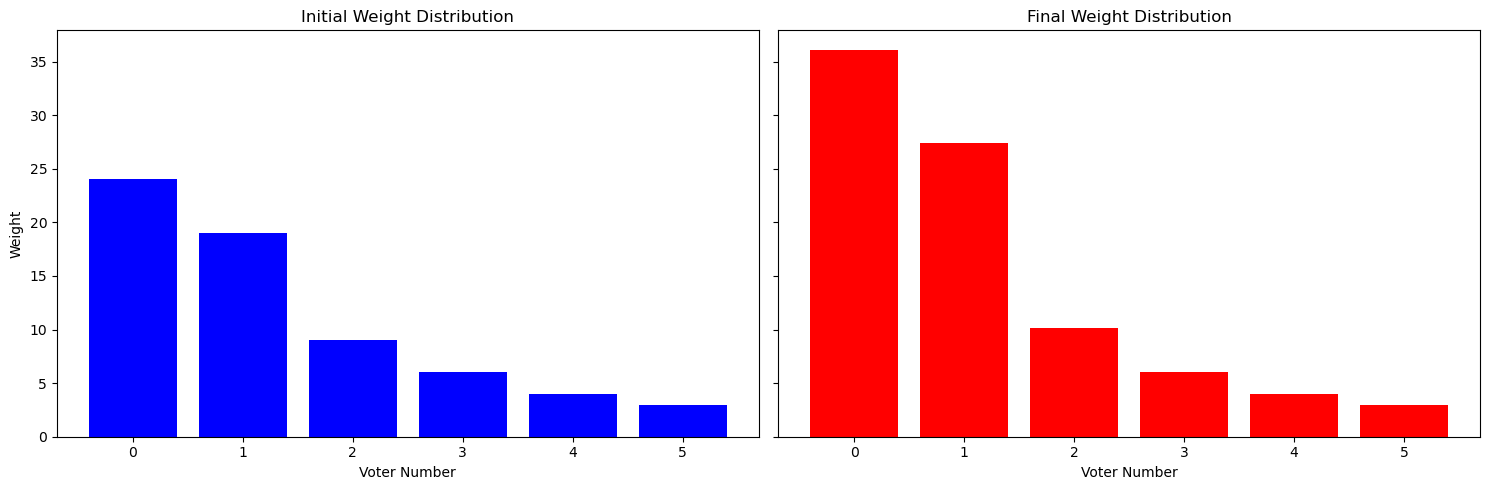

In [38]:
comparison_bar_distributions(initial_voter_weights_data, final_voter_weights_data)

## Visualizing Impact of Re-weighting


In [39]:
from mechanisms.percentage_allocation_weighted_plurality import PercentageAllocationWeightedPlurality
from mechanisms.simple_weighting_mechanism import SimpleCredentialWeightingMechanism

from metrics.plutocracy import calc_nakamoto_coefficient_additive

from utils.conversion import convert_voter_cred_df_to_dict

## Selecting a Voting Rule

The properties of the voting are sensitive to the **aggregation rule** (vote processing rule) that turns ballots into winners, based on voter weights, as much as they are voter weights.

For the time being we assume rules possess **monotonicity**. For this example, we use a simple percentage allocation mechanism. 

In [40]:
voting_mechanism = PercentageAllocationWeightedPlurality()

## Simulating and Visualizing Metrics

To see the range of possible outcomes, it's helpful to use *simulations* and *metrics*. 

### Nakamoto Coefficient

The *Nakamoto Coefficient* is a well-known metric for assessing decentralization in voting systems, particularly **1token1vote** systems. The Nakamoto Coefficient assesses: what is the smallest number of voters who could completely determine the outcome, assuming they all voted the same way? 

In [41]:
final_nakamoto_coefficient = calc_nakamoto_coefficient_additive(final_voter_weights)
print(f"The Nakamoto Coefficient for the final weights is: {final_nakamoto_coefficient}.")

The Nakamoto Coefficient for the final weights is: 2.


In an actual vote, the voter turnout matters a lot. This is where *simulations* come in. 
In the cell below, the code calculates the Nakamoto Coefficient for a number of potential voter turnout scenarios, 

In [42]:
from utils.sampling import samples_voting_population_by_pct_range

In [43]:
# Demonstration of how the sampling works. 

NUM_SAMPLES = 10
MIN_PCT = 0.25
MAX_PCT = 0.75

final_voter_population_samples = samples_voting_population_by_pct_range(input_dict = final_voter_weights,
                                       num_samples = NUM_SAMPLES,
                                       min_pct = MIN_PCT,
                                       max_pct = MAX_PCT)

In [44]:
final_nakamoto_coefficients = [calc_nakamoto_coefficient_additive(sample) for sample in final_voter_population_samples]

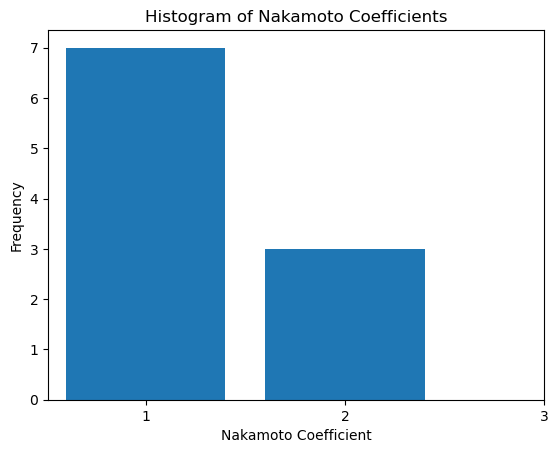

In [45]:
# Visualizing Nakamoto Coefficient

plt.hist(final_nakamoto_coefficients, 
         bins=range(1, max(final_nakamoto_coefficients)+2),
          align='left', 
          rwidth=0.8, 
          histtype='bar')
plt.title('Histogram of Nakamoto Coefficients')
plt.xlabel('Nakamoto Coefficient')
plt.ylabel('Frequency')
plt.xticks(range(1, max(final_nakamoto_coefficients)+2))
plt.show()